In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt

# Загрузка данных из локального файла
data = pd.read_csv('C:\\Users\\nikel\\Desktop\\MAI_AI\\Lab3\\movies_subtitles.csv')

# Предобработка данных: удаление пропущенных значений
data['text'] = data['text'].fillna('')

# Уменьшение размера данных: использование только первых 10000 строк
data = data.head(10000)

# Токенизация и преобразование текста в последовательности
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'].values.tolist())
total_words = len(tokenizer.word_index) + 1

# Определение максимальной длины последовательности
input_sequences = [tokenizer.texts_to_sequences([line])[0] for line in data['text'].values.tolist()]
max_sequence_len = max([len(x) for x in input_sequences])

# Определение генератора данных
class DataGenerator(Sequence):
    def __init__(self, data, tokenizer, max_sequence_len, batch_size=32, total_words=10000, **kwargs):
        super().__init__(**kwargs)
        self.data = data
        self.tokenizer = tokenizer
        self.max_sequence_len = max_sequence_len
        self.batch_size = batch_size
        self.total_words = total_words
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_data = self.data[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(batch_data)
        return X, y

    def on_epoch_end(self):
        np.random.shuffle(self.data)

    def __data_generation(self, batch_data):
        input_sequences = []
        for line in batch_data:
            token_list = self.tokenizer.texts_to_sequences([line])[0]
            for i in range(1, len(token_list)):
                n_gram_sequence = token_list[:i+1]
                input_sequences.append(n_gram_sequence)
        input_sequences = np.array(pad_sequences(input_sequences, maxlen=self.max_sequence_len, padding='pre'))
        X, y = input_sequences[:,:-1], input_sequences[:,-1]
        y = to_categorical(y, num_classes=self.total_words)
        return X, y

# Использование генератора данных
training_generator = DataGenerator(data['text'].values.tolist(), tokenizer, max_sequence_len, total_words=total_words)

In [17]:
# Определение модели трансформера с регуляризацией
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, regularizer=None):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu", kernel_regularizer=regularizer)(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1], kernel_regularizer=regularizer)(x)
    return Add()([x, res])

def build_model(max_len, total_words, num_layers=4, head_size=64, num_heads=4, ff_dim=128, dropout=0.1, regularizer=l2(0.01)):
    inputs = Input(shape=(max_len-1,))
    x = Embedding(total_words, 64)(inputs)
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout, regularizer)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)
    outputs = Dense(total_words, activation='softmax')(x)
    return Model(inputs, outputs)

In [18]:
# Построение модели с регуляризацией
model = build_model(max_sequence_len, total_words, num_layers=6, head_size=128, num_heads=8, ff_dim=256, dropout=0.2, regularizer=l2(0.01))

In [19]:
# Компиляция модели с AdamW
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

In [20]:
history = model.fit(training_generator, epochs=50, verbose=1)

Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 194s 555ms/step - accuracy: 0.0259 - loss: 18.1340
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 1619s 5s/step - accuracy: 0.0408 - loss: 12.0885
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 520s 2s/step - accuracy: 0.0495 - loss: 9.1743
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 495s 2s/step - accuracy: 0.0641 - loss: 7.6231
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.0743 - loss: 6.8005
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 368s 1s/step - accuracy: 0.0838 - loss: 6.3069
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 241s 772ms/step - accuracy: 0.0924 - loss: 6.0882
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 187s 599ms/step - accuracy: 0.0967 - loss: 5.8920
Epoch 9/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.1056 - loss: 5.7854
Epoch 10/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 474s 2s/step - accuracy: 0.1088 - loss: 5.6682
Epoch 11/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 214s 685ms/step - accuracy: 0.1136 - loss: 5.5738
Epoch 12/50
312/312 ━━━━━━

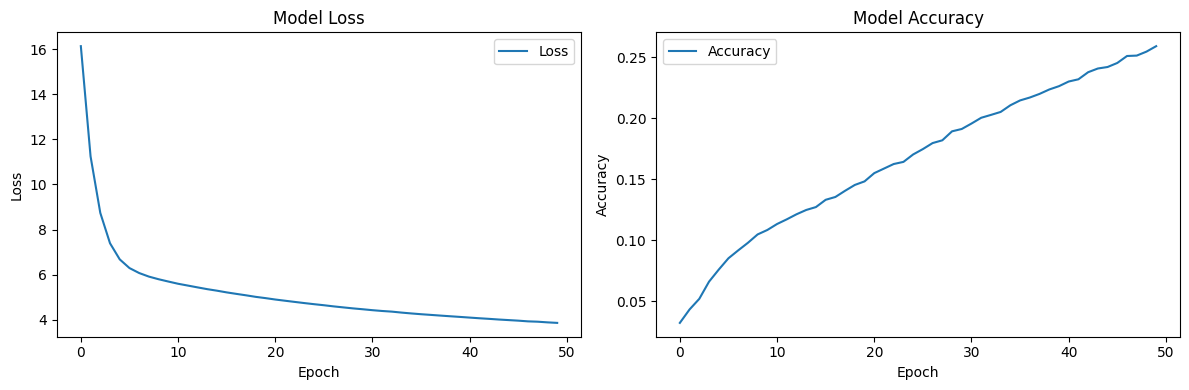

In [21]:
# Построение графиков
plt.figure(figsize=(12, 4))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Генерация текста
def generate_text(seed_text, max_sequence_len, tokenizer, model, temperature=1.0):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    generated_text = seed_text

    while True:
        token_list_padded = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predictions = model.predict(token_list_padded, verbose=0)
        predictions = predictions / temperature  # Adjust temperature
        predicted_index = np.argmax(predictions, axis=-1)[0]

        predicted_word = tokenizer.index_word.get(predicted_index, '')

        if predicted_word == '' or len(generated_text.split()) >= max_sequence_len:
            break

        generated_text += " " + predicted_word
        token_list.append(predicted_index)

    return generated_text

In [37]:
# Пример генерации текста
print(generate_text("Where my", max_sequence_len, tokenizer, model))

Where my is the own headphones woodpecker bitter banque i i was i was i didn't didn't have have


В ходе работы эту модель приходилось множество раз дорабатывать и улучшать, так от первоначального варианта данный трансформер отличается возможностью самостоятельно подбирать оптимальное количество символов для ответа (а не по указанию необходимого количества слов для вывода), были добавлены несколько слоев энкодеров, а также добавлено больше нейронов в полносвязные слои, регуляризация Dropout, L2-регуляризация, чтобы снизить вероятность переобучения. 
Я проводил обучение с разными настройками параметров, но мне так и не удалось достигнуть хорошего результата. Мне кажется, для лучшего обучения стоит использовать более мощное "железо", имеет смысл продолжать эксперименты с настройками и структурой трансформера.